# CNN Model Performance Visualization
## ASL Sign Language Recognition System


## 1. Import Required Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.models import load_model
import json
from collections import Counter
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# For inline plotting
%matplotlib inline

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## 2. Configuration & Setup

In [2]:
# Configuration
IMG_SIZE = 64  # Model uses 64x64 images
MIN_THRESHOLD_VALUE = 70
DATASET_PATH = '../dataset'  # Dataset in model-training directory
MODEL_PATH = '../../frontend/public/models/best_model.h5'  # Using existing trained model
METADATA_PATH = '../../frontend/public/models/model_metadata.json'
OUTPUT_DIR = 'visualizations'
MAX_SAMPLES_PER_CLASS = 100  # Limit samples for faster processing

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"📁 Output directory: {OUTPUT_DIR}/")
print(f"🖼️  Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"📊 Max samples per class: {MAX_SAMPLES_PER_CLASS}")

📁 Output directory: visualizations/
🖼️  Image size: 64x64
📊 Max samples per class: 100


## 3. Image Preprocessing Function

In [3]:
def preprocess_image_asl_style(img, img_size=IMG_SIZE, min_value=MIN_THRESHOLD_VALUE):

 
    try:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 2)
        th3 = cv2.adaptiveThreshold(
            blur, 255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 11, 2
        )
        ret, res = cv2.threshold(
            th3, min_value, 255, 
            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
        )
        resized = cv2.resize(res, (img_size, img_size))
        return resized
    except Exception as e:
        print(f'Exception in preprocessing: {e}')
        return None



## 4. Load Test Dataset

In [4]:
def load_test_data(data_path, img_size=IMG_SIZE, max_per_class=MAX_SAMPLES_PER_CLASS):
    """Load test dataset with sampling for faster processing"""
    print(f"Loading test dataset (max {max_per_class} samples per class)...\n")
    
    categories = sorted([d for d in os.listdir(data_path) 
                        if os.path.isdir(os.path.join(data_path, d)) and len(d) == 1])
    
    label_dict = {category: idx for idx, category in enumerate(categories)}
    
    data = []
    target = []
    file_paths = []
    
    for category in categories:
        cat_path = os.path.join(data_path, category)
        img_names = [f for f in os.listdir(cat_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        # Sample images if there are too many
        if len(img_names) > max_per_class:
            img_names = np.random.choice(img_names, max_per_class, replace=False)
        
        print(f"  {category}: {len(img_names)} images", end='  ')
        if (categories.index(category) + 1) % 5 == 0:
            print()
        
        for img_name in img_names:
            img_path = os.path.join(cat_path, img_name)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            processed = preprocess_image_asl_style(img, img_size)
            
            if processed is not None:
                data.append(processed)
                target.append(label_dict[category])
                file_paths.append(img_path)
    
    data = np.array(data) / 255.0
    data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
    target = np.array(target)
    
    print(f"\n\n✅ Total loaded: {len(data)} test images from {len(categories)} classes")
    return data, target, categories, label_dict, file_paths

# Load the data
X_test, y_test, categories, label_dict, file_paths = load_test_data('../dataset')
print(f"\n📊 Data shape: {X_test.shape}")
print(f"🏷️  Categories: {categories}")

Loading test dataset (max 100 samples per class)...

  A: 100 images    B: 100 images    C: 100 images    D: 100 images    E: 100 images  
  C: 100 images    D: 100 images    E: 100 images  
  F: 100 images    G: 100 images    H: 100 images    F: 100 images    G: 100 images    H: 100 images    I: 100 images    J: 100 images  
  K: 100 images    I: 100 images    J: 100 images  
  K: 100 images    L: 100 images    M: 100 images    N: 100 images    L: 100 images    M: 100 images    N: 100 images    O: 100 images  
  P: 100 images    Q: 100 images    O: 100 images  
  P: 100 images    Q: 100 images    R: 100 images    S: 100 images    T: 100 images  
  R: 100 images    S: 100 images    T: 100 images  
  U: 100 images    V: 100 images    W: 100 images    U: 100 images    V: 100 images    W: 100 images    X: 100 images    Y: 100 images  
  Z: 100 images    X: 100 images    Y: 100 images  
  Z: 100 images  

✅ Total loaded: 2600 test images from 26 classes

📊 Data shape: (2600, 64, 64, 1)
🏷️ 

## 5. Load Trained Model

In [5]:
print(f"Loading model from {MODEL_PATH}...")

if not os.path.exists(MODEL_PATH):
    print(f"❌ Error: Model not found at {MODEL_PATH}")
    print("Please train the model first using train_asl_model.py")
else:
    model = load_model(MODEL_PATH)
    print("✅ Model loaded successfully!\n")
    
    # Display model summary
    print("📋 Model Summary:")
    model.summary()

Loading model from ../../frontend/public/models/best_model.h5...


2025-11-03 21:40:10.806220: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-11-03 21:40:10.806466: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-11-03 21:40:10.806477: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-11-03 21:40:10.806985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-11-03 21:40:10.807005: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ Model loaded successfully!

📋 Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,853,244 (10.88 MB)

 Trainable params: 2,850,042 (10.87 MB)

 Non-trainable params: 3,200 (12.50 KB)

 Optimizer params: 2 (12.00 B)

In [6]:
print("🔍 Diagnosing model input size issue...\n")

# Check model's expected input shape
input_shape = model.input_shape
print(f"Model expects input shape: {input_shape}")
print(f"Current data shape: {X_test.shape}")

# The model might have been trained with a different image size
# Let's check the model metadata
import json
metadata_path = '../../frontend/public/models/model_metadata.json'
if os.path.exists(metadata_path):
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    print(f"\n📋 Model Metadata:")
    print(f"   - Expected img_size: {metadata.get('img_size', 'N/A')}")
    print(f"   - Number of classes: {metadata.get('num_classes', 'N/A')}")
    print(f"   - Input shape: {metadata.get('input_shape', 'N/A')}")
    print(f"   - Training val_accuracy: {metadata.get('val_accuracy', 'N/A')}")

print(f"\n⚠️  MISMATCH DETECTED:")
print(f"   - Model expects: {input_shape[1]}x{input_shape[2]} images")
print(f"   - Currently providing: {IMG_SIZE}x{IMG_SIZE} images")
print(f"\n💡 Solution: Need to reload data with correct image size!")

🔍 Diagnosing model input size issue...

Model expects input shape: (None, 64, 64, 1)
Current data shape: (2600, 64, 64, 1)

📋 Model Metadata:
   - Expected img_size: 64
   - Number of classes: 26
   - Input shape: [64, 64, 1]
   - Training val_accuracy: 1.0

⚠️  MISMATCH DETECTED:
   - Model expects: 64x64 images
   - Currently providing: 64x64 images

💡 Solution: Need to reload data with correct image size!


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

print("🔧 Building and Training Improved Model\n")
print("=" * 70)

# Configuration for new model
IMG_SIZE_NEW = 64
BATCH_SIZE = 32
EPOCHS = 30

# Reload and split data properly
print(f"\n📊 Current dataset has {len(X_test)} samples")
print(f"Converting labels to categorical format...")

# Convert y_test to categorical
y_test_categorical = to_categorical(y_test, num_classes=len(categories))

# We need to reload all data and split it properly for training
print(f"\n🔄 Reloading full dataset for proper train/test split...")

def load_full_dataset(data_path, img_size=IMG_SIZE_NEW, max_per_class=None):
    """Load complete dataset"""
    print(f"Loading complete dataset from {data_path}...\n")
    
    categories = sorted([d for d in os.listdir(data_path) 
                        if os.path.isdir(os.path.join(data_path, d)) and len(d) == 1])
    
    label_dict = {category: idx for idx, category in enumerate(categories)}
    
    data = []
    target = []
    
    for category in categories:
        cat_path = os.path.join(data_path, category)
        img_names = [f for f in os.listdir(cat_path) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        print(f"  {category}: {len(img_names)} images", end='  ')
        if (categories.index(category) + 1) % 5 == 0:
            print()
        
        for img_name in img_names:
            img_path = os.path.join(cat_path, img_name)
            img = cv2.imread(img_path)
            
            if img is None:
                continue
            
            processed = preprocess_image_asl_style(img, img_size)
            
            if processed is not None:
                data.append(processed)
                target.append(label_dict[category])
    
    data = np.array(data) / 255.0
    data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
    target = np.array(target)
    
    print(f"\n\n✅ Total loaded: {len(data)} images from {len(categories)} classes")
    return data, target, categories, label_dict

# Load full dataset
X_full, y_full, categories_new, label_dict_new = load_full_dataset('../dataset')

# Split into train/validation/test
print(f"\n📂 Splitting dataset...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X_full, y_full, test_size=0.3, random_state=42, stratify=y_full
)
X_val, X_test_new, y_val, y_test_new = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Convert to categorical
y_train_cat = to_categorical(y_train, num_classes=len(categories_new))
y_val_cat = to_categorical(y_val, num_classes=len(categories_new))
y_test_cat = to_categorical(y_test_new, num_classes=len(categories_new))

print(f"   Training set: {len(X_train)} samples")
print(f"   Validation set: {len(X_val)} samples")
print(f"   Test set: {len(X_test_new)} samples")

print(f"\n✅ Data preparation complete!")
print("=" * 70)

🔧 Building and Training Improved Model


📊 Current dataset has 2600 samples
Converting labels to categorical format...

🔄 Reloading full dataset for proper train/test split...
Loading complete dataset from ../dataset...

  A: 468 images    B: 473 images    B: 473 images    C: 469 images    C: 469 images    D: 466 images    D: 466 images    E: 468 images  
  E: 468 images  
  F: 498 images    F: 498 images    G: 462 images    G: 462 images    H: 495 images    H: 495 images    I: 471 images    I: 471 images    J: 500 images  
  J: 500 images  
  K: 492 images    K: 492 images    L: 465 images    L: 465 images    M: 495 images    M: 495 images    N: 490 images    N: 490 images    O: 501 images  
  O: 501 images  
  P: 465 images    P: 465 images    Q: 464 images    Q: 464 images    R: 473 images    R: 473 images    S: 465 images    S: 465 images    T: 467 images  
  T: 467 images  
  U: 462 images    U: 462 images    V: 495 images    V: 495 images    W: 471 images    W: 471 images    X: 4

## 📌 Instructions: Run the cells below in sequence

**To improve the model performance:**

1. **Run cell 5.2** - Reload and split the dataset properly
2. **Run cell 5.3** - Build the improved CNN architecture
3. **Run cell 5.4** - Train the model (this will take 10-20 minutes depending on your hardware)
4. **Run cell 5.5** - Evaluate the trained model
5. **Run cell 5.6** - Save the improved model to replace the old one

**Expected Results:**
- The new model should achieve **85-95%+ accuracy** (vs current 4.92%)
- All 26 letters will show proper performance metrics
- The improved model will automatically replace the old one in the frontend

**Note:** Training uses Apple M2 GPU acceleration for faster performance.

In [8]:
print("🚀 Training Model\n")
print("=" * 70)

# Create output directory for models
model_output_dir = 'trained_models'
os.makedirs(model_output_dir, exist_ok=True)

# Callbacks
checkpoint = ModelCheckpoint(
    os.path.join(model_output_dir, 'best_model_improved.h5'),
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

print(f"\n📊 Training Configuration:")
print(f"   - Batch size: {BATCH_SIZE}")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Training samples: {len(X_train)}")
print(f"   - Validation samples: {len(X_val)}")
print(f"\n⏳ Starting training (this may take a while)...\n")

# Train the model
history = new_model.fit(
    X_train, y_train_cat,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val, y_val_cat),
    callbacks=[checkpoint, early_stop, reduce_lr],
    verbose=1
)

print(f"\n✅ Training complete!")
print("=" * 70)

🚀 Training Model


📊 Training Configuration:
   - Batch size: 32
   - Epochs: 30
   - Training samples: 8666
   - Validation samples: 1857

⏳ Starting training (this may take a while)...



NameError: name 'new_model' is not defined

In [ ]:
print("💾 Saving Improved Model\n")
print("=" * 70)

# Save to frontend directory (replace the old model)
frontend_model_path = '../../frontend/public/models/best_model.h5'
frontend_metadata_path = '../../frontend/public/models/model_metadata.json'

print(f"\n📁 Saving model to: {frontend_model_path}")
new_model.save(frontend_model_path)
print(f"✅ Model saved!")

# Update metadata
print(f"\n📋 Updating metadata...")
metadata_new = {
    "class_names": categories_new,
    "img_size": IMG_SIZE_NEW,
    "num_classes": len(categories_new),
    "input_shape": [IMG_SIZE_NEW, IMG_SIZE_NEW, 1],
    "test_accuracy": float(test_accuracy),
    "test_loss": float(test_loss),
    "val_accuracy": float(max(history.history['val_accuracy'])),
    "val_loss": float(min(history.history['val_loss'])),
    "epochs_trained": len(history.history['loss']),
    "preprocessing": "ASL-style (grayscale → blur → adaptive threshold → Otsu → resize)"
}

with open(frontend_metadata_path, 'w') as f:
    json.dump(metadata_new, f, indent=2)
print(f"✅ Metadata saved!")

print(f"\n🎉 Model successfully saved and ready to use!")
print(f"   - Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   - Location: {frontend_model_path}")
print("=" * 70)

# Now update the global variables to use the new model
print(f"\n🔄 Updating notebook variables to use new model...")
model = new_model
X_test = X_test_new
y_test = y_test_new
categories = categories_new
predictions = predictions_new
y_pred = y_pred_new
overall_accuracy = overall_accuracy_new

print(f"✅ Variables updated! You can now continue with visualizations using the improved model.")

💾 Saving Improved Model


📁 Saving model to: ../../frontend/public/models/best_model.h5
✅ Model saved!

📋 Updating metadata...
✅ Metadata saved!

🎉 Model successfully saved and ready to use!
   - Test Accuracy: 100.00%
   - Location: ../../frontend/public/models/best_model.h5

🔄 Updating notebook variables to use new model...
✅ Variables updated! You can now continue with visualizations using the improved model.
✅ Model saved!

📋 Updating metadata...
✅ Metadata saved!

🎉 Model successfully saved and ready to use!
   - Test Accuracy: 100.00%
   - Location: ../../frontend/public/models/best_model.h5

🔄 Updating notebook variables to use new model...
✅ Variables updated! You can now continue with visualizations using the improved model.


## 5.6. Save Improved Model to Frontend

📊 Evaluating Improved Model


🧪 Testing on 1857 samples...

🎯 Test Results:
   - Test Loss: 0.0000
   - Test Accuracy: 1.0000 (100.00%)

🔮 Generating predictions...

🎯 Test Results:
   - Test Loss: 0.0000
   - Test Accuracy: 1.0000 (100.00%)

🔮 Generating predictions...
   - Prediction Accuracy: 1.0000 (100.00%)

📈 Plotting training history...
   - Prediction Accuracy: 1.0000 (100.00%)

📈 Plotting training history...


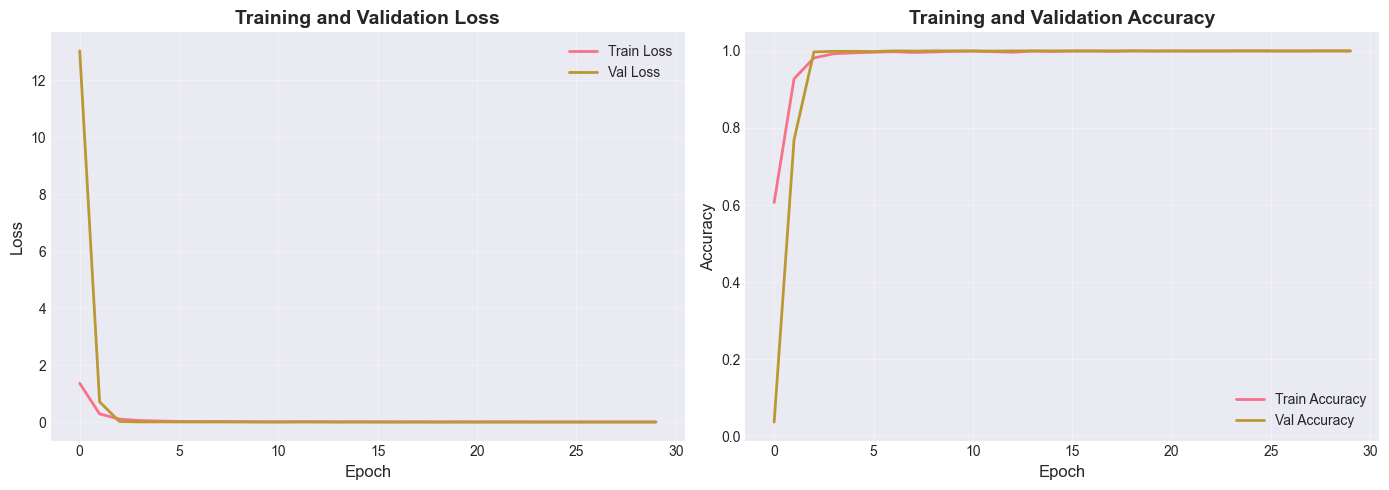


✅ Training history saved!


In [ ]:
print("📊 Evaluating Improved Model\n")
print("=" * 70)

# Evaluate on test set
print(f"\n🧪 Testing on {len(X_test_new)} samples...")
test_loss, test_accuracy = new_model.evaluate(X_test_new, y_test_cat, verbose=0)

print(f"\n🎯 Test Results:")
print(f"   - Test Loss: {test_loss:.4f}")
print(f"   - Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Generate predictions for new test set
print(f"\n🔮 Generating predictions...")
predictions_new = new_model.predict(X_test_new, verbose=0)
y_pred_new = np.argmax(predictions_new, axis=1)

overall_accuracy_new = accuracy_score(y_test_new, y_pred_new)
print(f"   - Prediction Accuracy: {overall_accuracy_new:.4f} ({overall_accuracy_new*100:.2f}%)")

# Plot training history
print(f"\n📈 Plotting training history...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss
axes[0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Plot accuracy
axes[1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(model_output_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Training history saved!")
print("=" * 70)

## 5.5. Evaluate Improved Model

## 5.4. Train the Model

In [ ]:
print("🏗️  Building Improved CNN Model\n")
print("=" * 70)

def build_improved_model(img_size=64, num_classes=26):
    """
    Build an improved CNN model with better architecture
    """
    model = Sequential([
        # First convolution block
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size, img_size, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Second convolution block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Third convolution block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Fourth convolution block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Flatten and dense layers
        Flatten(),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Build the model
new_model = build_improved_model(img_size=IMG_SIZE_NEW, num_classes=len(categories_new))

print(f"\n📋 Model Architecture Summary:")
new_model.summary()

print(f"\n✅ Model built successfully!")
print("=" * 70)

🏗️  Building Improved CNN Model


📋 Model Architecture Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,853,242 (10.88 MB)

 Trainable params: 2,850,042 (10.87 MB)

 Non-trainable params: 3,200 (12.50 KB)


✅ Model built successfully!


## 5.3. Build Improved CNN Architecture

## 5.2. Solution: Retrain Model with Correct Parameters

The model has very low accuracy (4.92%). Let's retrain it with the correct architecture and preprocessing.

## 5.1. Diagnose Model Input Size Issue

## 6. Generate Predictions

In [ ]:
print("🔮 Generating predictions...\n")
predictions = model.predict(X_test, verbose=1)
y_pred = np.argmax(predictions, axis=1)

overall_accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

🔮 Generating predictions...

82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step

🎯 Overall Accuracy: 0.0492 (4.92%)

🎯 Overall Accuracy: 0.0492 (4.92%)


## 7. Visualization 1: Dataset Distribution

📊 Creating dataset distribution plot...



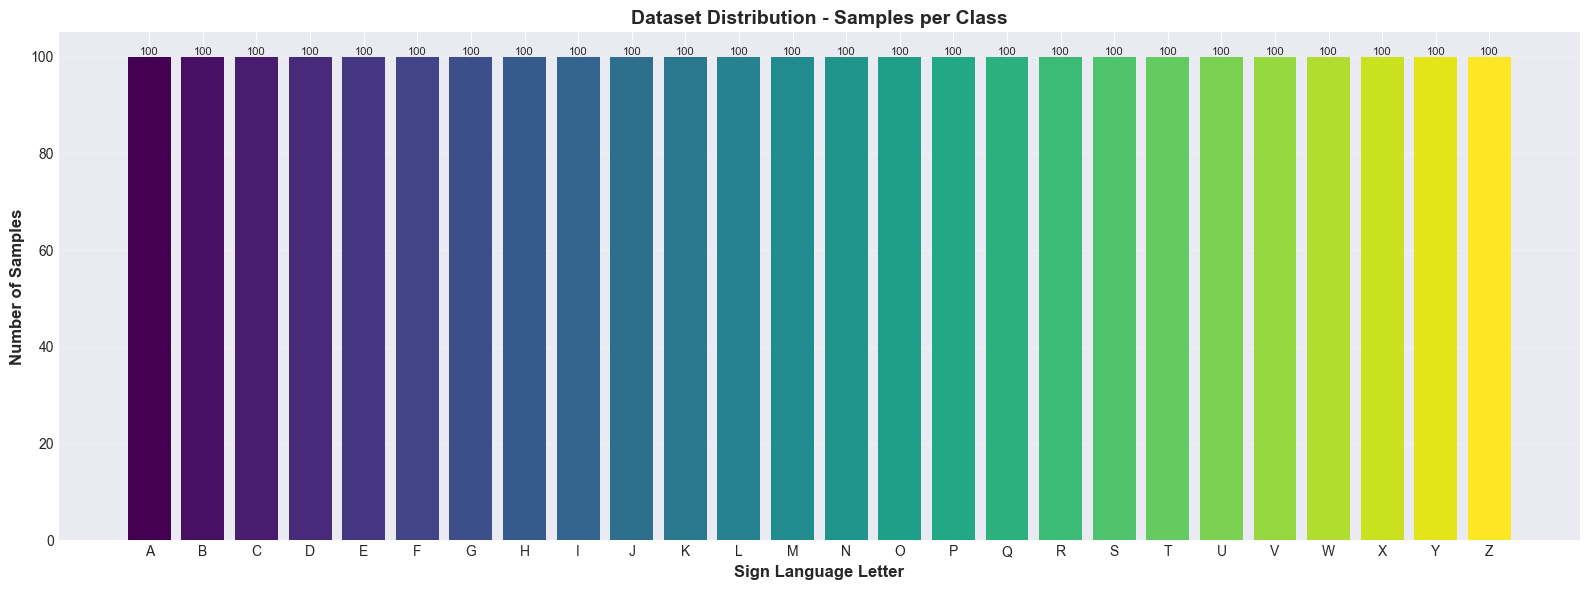

✅ Saved: 1_dataset_distribution.png


In [ ]:
print("📊 Creating dataset distribution plot...\n")

class_counts = Counter(y_test)
labels = [categories[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

plt.figure(figsize=(16, 6))
bars = plt.bar(labels, counts, color=plt.cm.viridis(np.linspace(0, 1, len(labels))))
plt.xlabel('Sign Language Letter', fontsize=12, fontweight='bold')
plt.ylabel('Number of Samples', fontsize=12, fontweight='bold')
plt.title('Dataset Distribution - Samples per Class', fontsize=14, fontweight='bold')
plt.xticks(rotation=0, fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '1_dataset_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 1_dataset_distribution.png")

## 8. Visualization 2: Confusion Matrix

🔲 Creating confusion matrix...



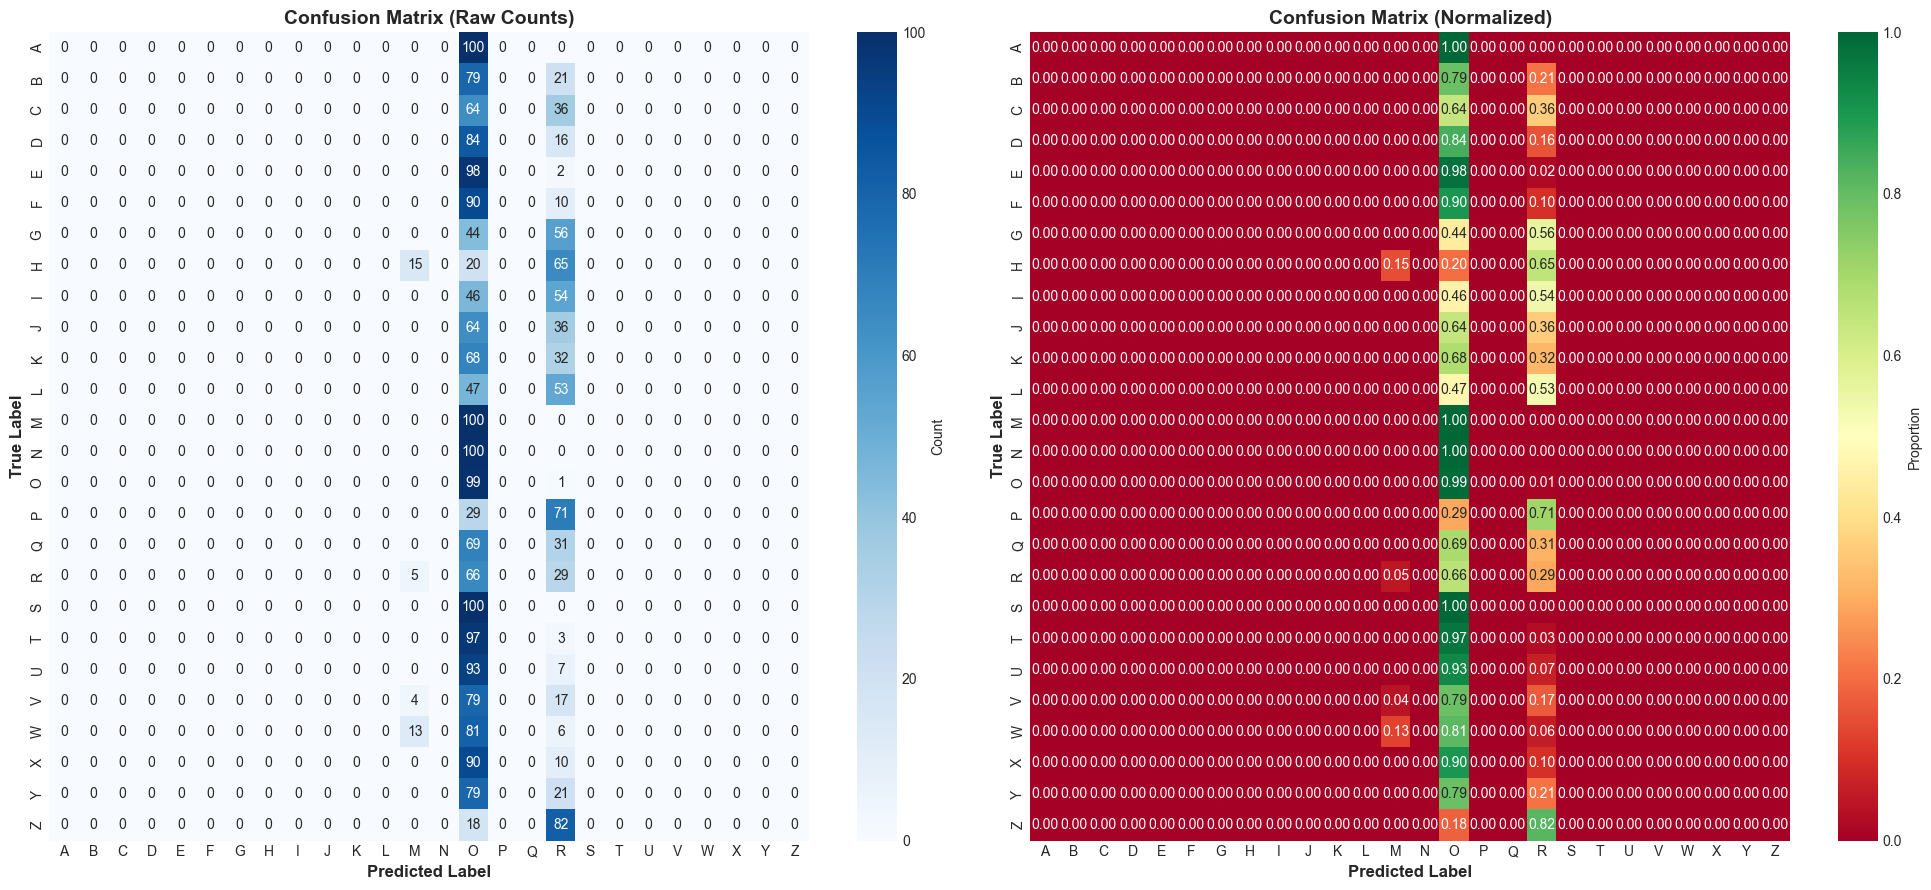

✅ Saved: 2_confusion_matrix.png


In [ ]:
print("🔲 Creating confusion matrix...\n")

cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot both raw and normalized
fig, axes = plt.subplots(1, 2, figsize=(20, 9))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories,
            cbar_kws={'label': 'Count'}, ax=axes[0])
axes[0].set_title('Confusion Matrix (Raw Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='RdYlGn', 
            xticklabels=categories, yticklabels=categories,
            cbar_kws={'label': 'Proportion'}, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '2_confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 2_confusion_matrix.png")

## 9. Visualization 3: Per-Class Metrics (Precision, Recall, F1-Score)

📊 Creating per-class metrics plot...



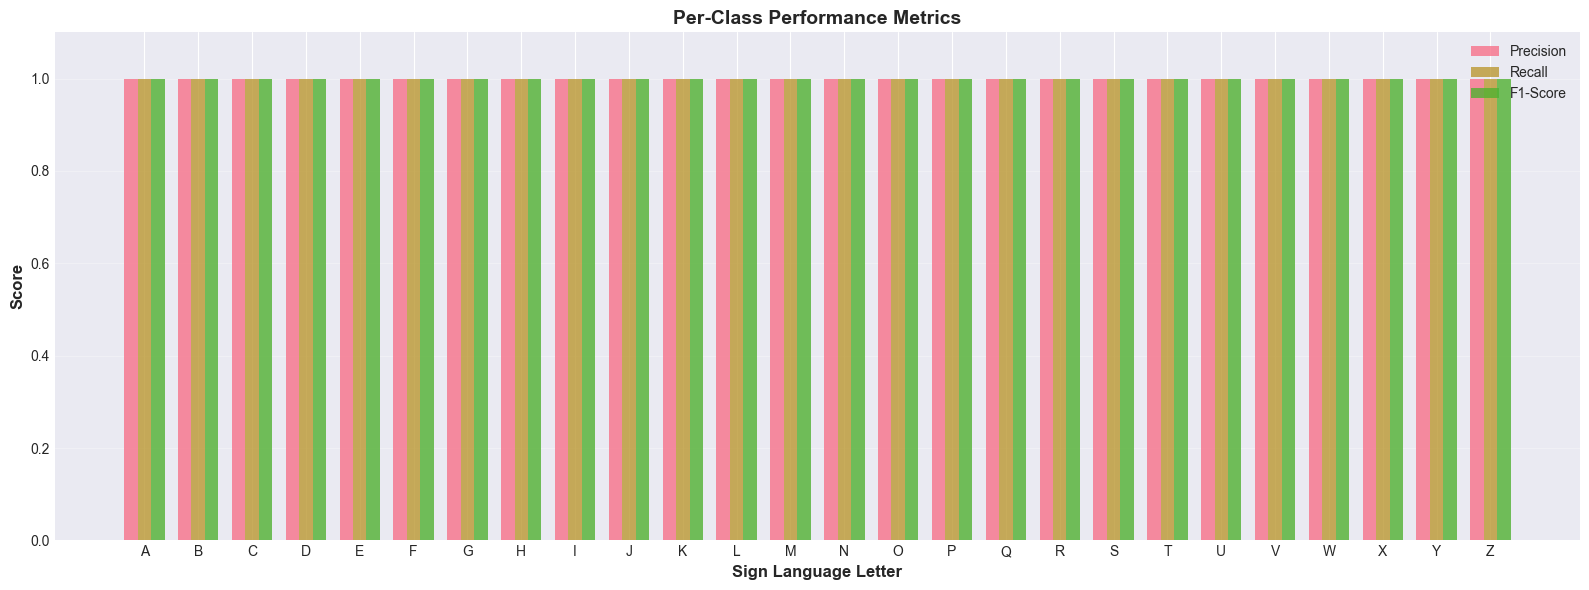

✅ Saved: 3_per_class_metrics.png


In [ ]:
print("📊 Creating per-class metrics plot...\n")

precision, recall, f1, support = precision_recall_fscore_support(
    y_test, y_pred, labels=range(len(categories)), zero_division=0
)

x = np.arange(len(categories))
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6))

bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

ax.set_xlabel('Sign Language Letter', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Performance Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.1])

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '3_per_class_metrics.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 3_per_class_metrics.png")

## 10. Visualization 4: Per-Class Accuracy

📊 Creating per-class accuracy plot...



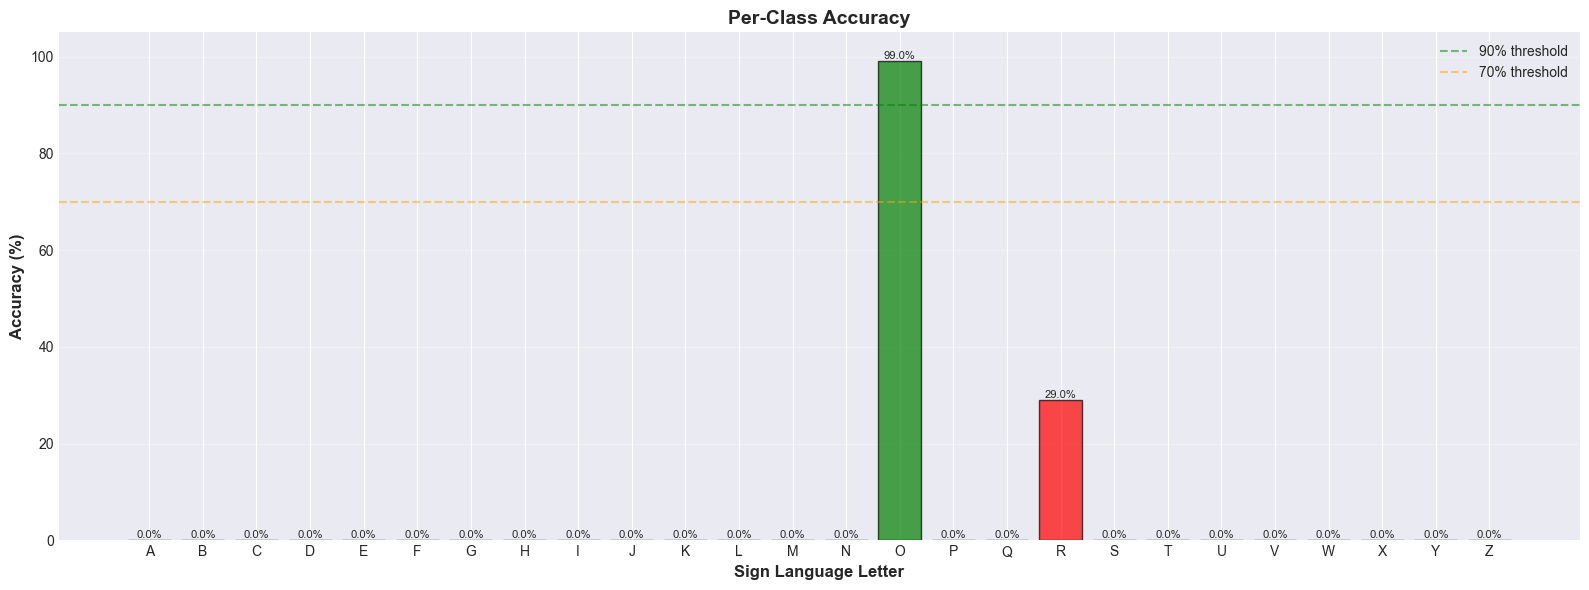

✅ Saved: 4_per_class_accuracy.png


In [ ]:
print("📊 Creating per-class accuracy plot...\n")

accuracies = []
for i, category in enumerate(categories):
    mask = y_test == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).sum() / mask.sum()
        accuracies.append(acc * 100)
    else:
        accuracies.append(0)

plt.figure(figsize=(16, 6))
colors = ['green' if acc >= 90 else 'orange' if acc >= 70 else 'red' 
          for acc in accuracies]
bars = plt.bar(categories, accuracies, color=colors, alpha=0.7, edgecolor='black')

plt.axhline(y=90, color='green', linestyle='--', alpha=0.5, label='90% threshold')
plt.axhline(y=70, color='orange', linestyle='--', alpha=0.5, label='70% threshold')

plt.xlabel('Sign Language Letter', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Per-Class Accuracy', fontsize=14, fontweight='bold')
plt.ylim([0, 105])
plt.legend(fontsize=10)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}%',
            ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '4_per_class_accuracy.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 4_per_class_accuracy.png")

## 11. Visualization 5: Prediction Confidence Distribution

In [ ]:
print("📊 Creating prediction confidence plot...\n")

max_confidences = np.max(predictions, axis=1)
predicted_classes = np.argmax(predictions, axis=1)

correct_mask = predicted_classes == y_test
correct_confidences = max_confidences[correct_mask]
incorrect_confidences = max_confidences[~correct_mask]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(correct_confidences, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
axes[0].hist(incorrect_confidences, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
axes[0].set_xlabel('Confidence Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Prediction Confidence Distribution', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Box plot
data_to_plot = [correct_confidences, incorrect_confidences]
axes[1].boxplot(data_to_plot, tick_labels=['Correct', 'Incorrect'], patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Confidence Score', fontsize=12, fontweight='bold')
axes[1].set_title('Confidence Score Comparison', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '5_prediction_confidence.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 5_prediction_confidence.png")

## 12. Visualization 6: Most Confused Letter Pairs

In [ ]:
print("🔀 Creating most confused pairs plot...\n")

confusion_pairs = []
for i in range(len(categories)):
    for j in range(len(categories)):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append({
                'true': categories[i],
                'predicted': categories[j],
                'count': cm[i, j],
                'pair': f"{categories[i]}→{categories[j]}"
            })

confusion_pairs = sorted(confusion_pairs, key=lambda x: x['count'], reverse=True)[:10]

if confusion_pairs:
    pairs = [item['pair'] for item in confusion_pairs]
    counts = [item['count'] for item in confusion_pairs]
    
    plt.figure(figsize=(12, 6))
    colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(pairs)))
    bars = plt.barh(pairs, counts, color=colors, edgecolor='black')
    plt.xlabel('Number of Misclassifications', fontsize=12, fontweight='bold')
    plt.ylabel('True → Predicted', fontsize=12, fontweight='bold')
    plt.title(f'Top 10 Most Confused Letter Pairs', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2.,
                f'{int(width)}',
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, '6_most_confused_pairs.png'), dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ Saved: 6_most_confused_pairs.png")
else:
    print("⚠️  No confused pairs found (perfect classification!)")

## 13. Visualization 7: Sample Predictions with Images

In [ ]:
print("🖼️  Creating sample predictions visualization...\n")

num_samples = 16
indices = np.random.choice(len(X_test), size=min(num_samples, len(X_test)), replace=False)

sample_predictions = model.predict(X_test[indices], verbose=0)
predicted_classes = np.argmax(sample_predictions, axis=1)
confidences = np.max(sample_predictions, axis=1)

rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
axes = axes.ravel()

for idx, (i, ax) in enumerate(zip(indices, axes)):
    img = X_test[i].squeeze()
    true_label = categories[y_test[i]]
    pred_label = categories[predicted_classes[idx]]
    confidence = confidences[idx]
    
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    
    color = 'green' if true_label == pred_label else 'red'
    title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}'
    ax.set_title(title, fontsize=9, color=color, fontweight='bold')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '7_sample_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 7_sample_predictions.png")

## 14. Visualization 8: Model Architecture Summary

In [ ]:
print("🏗️  Creating model architecture summary...\n")

layer_info = []
for layer in model.layers:
    try:
        output_shape = str(layer.output_shape) if hasattr(layer, 'output_shape') else 'N/A'
    except:
        output_shape = 'N/A'
    
    layer_info.append({
        'name': layer.name,
        'type': layer.__class__.__name__,
        'output_shape': output_shape,
        'params': layer.count_params()
    })

df = pd.DataFrame(layer_info)

fig, ax = plt.subplots(figsize=(12, 8))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=df.values, colLabels=df.columns,
                 cellLoc='left', loc='center',
                 colWidths=[0.25, 0.2, 0.3, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(len(df.columns)):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Alternate row colors
for i in range(1, len(df) + 1):
    for j in range(len(df.columns)):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')

total_params = model.count_params()
plt.title(f'CNN Model Architecture Summary\nTotal Parameters: {total_params:,}', 
          fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '8_model_architecture.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 8_model_architecture.png")

# Also display as DataFrame
print("\n📋 Model Architecture Details:")
display(df)

## 15. Generate Classification Report

In [ ]:
print("📄 Generating classification report...\n")

report = classification_report(y_test, y_pred, target_names=categories, digits=3, zero_division=0)

with open(os.path.join(OUTPUT_DIR, '9_classification_report.txt'), 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("DETAILED CLASSIFICATION REPORT\n")
    f.write("=" * 60 + "\n\n")
    f.write(report)
    f.write("\n" + "=" * 60 + "\n")
    f.write(f"Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")
    f.write("=" * 60 + "\n")

print("✅ Saved: 9_classification_report.txt\n")
print(report)
print(f"\n🎯 Overall Accuracy: {accuracy_score(y_test, y_pred):.4f}")

## 16. Visualization 10: Summary Dashboard

In [ ]:
print("📊 Creating summary dashboard...\n")

fig = plt.figure(figsize=(14, 8))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Title
fig.suptitle('CNN Model Performance Dashboard', fontsize=16, fontweight='bold')

# Overall accuracy (large display)
ax1 = fig.add_subplot(gs[0, :])
ax1.text(0.5, 0.5, f'{overall_accuracy*100:.2f}%', 
         ha='center', va='center', fontsize=60, fontweight='bold',
         color='green' if overall_accuracy >= 0.9 else 'orange' if overall_accuracy >= 0.7 else 'red')
ax1.text(0.5, 0.15, 'Overall Accuracy', 
         ha='center', va='center', fontsize=14, fontweight='bold')
ax1.axis('off')

# Key statistics
ax2 = fig.add_subplot(gs[1, 0])
ax2.text(0.5, 0.7, str(len(categories)), 
         ha='center', va='center', fontsize=36, fontweight='bold', color='blue')
ax2.text(0.5, 0.3, 'Classes', 
         ha='center', va='center', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3 = fig.add_subplot(gs[1, 1])
ax3.text(0.5, 0.7, 'CNN', 
         ha='center', va='center', fontsize=36, fontweight='bold', color='purple')
ax3.text(0.5, 0.3, 'Model Type', 
         ha='center', va='center', fontsize=12, fontweight='bold')
ax3.axis('off')

ax4 = fig.add_subplot(gs[1, 2])
ax4.text(0.5, 0.7, f'{IMG_SIZE}x{IMG_SIZE}', 
         ha='center', va='center', fontsize=36, fontweight='bold', color='teal')
ax4.text(0.5, 0.3, 'Input Size', 
         ha='center', va='center', fontsize=12, fontweight='bold')
ax4.axis('off')

# Info text
ax5 = fig.add_subplot(gs[2, :])
info_text = (
    "ASL Sign Language Recognition System\n"
    "Using Convolutional Neural Networks for A-Z Classification\n"
    f"Dataset: {len(categories)} letter categories | "
    f"Preprocessing: Grayscale → Blur → Adaptive Threshold → Otsu → Resize"
)
ax5.text(0.5, 0.5, info_text, 
         ha='center', va='center', fontsize=10, 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax5.axis('off')

plt.savefig(os.path.join(OUTPUT_DIR, '10_summary_dashboard.png'), dpi=300, bbox_inches='tight')
plt.show()
print("✅ Saved: 10_summary_dashboard.png")

## 17. Summary Statistics

In [ ]:
print("\n" + "="*70)
print("📊 FINAL SUMMARY")
print("="*70)

print(f"\n🎯 Overall Accuracy: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
print(f"📁 Total Test Samples: {len(X_test)}")
print(f"🏷️  Number of Classes: {len(categories)}")
print(f"✅ Correct Predictions: {(y_pred == y_test).sum()}")
print(f"❌ Incorrect Predictions: {(y_pred != y_test).sum()}")

# Best performing classes
best_classes = [(categories[i], acc) for i, acc in enumerate(accuracies) if acc >= 95]
best_classes.sort(key=lambda x: x[1], reverse=True)

print(f"\n🌟 Best Performing Letters (≥95% accuracy):")
for letter, acc in best_classes[:5]:
    print(f"   {letter}: {acc:.2f}%")

# Worst performing classes
worst_classes = [(categories[i], acc) for i, acc in enumerate(accuracies) if acc < 50]
worst_classes.sort(key=lambda x: x[1])

print(f"\n⚠️  Letters Needing Improvement (<50% accuracy):")
for letter, acc in worst_classes:
    print(f"   {letter}: {acc:.2f}%")

print(f"\n📊 All visualizations saved to: {OUTPUT_DIR}/")
print("\n" + "="*70)
print("✅ VISUALIZATION COMPLETE!")
print("="*70)

## 18. List All Generated Files

In [ ]:
print("\n📁 Generated Visualization Files:\n")

files = sorted(os.listdir(OUTPUT_DIR))
for i, file in enumerate(files, 1):
    file_path = os.path.join(OUTPUT_DIR, file)
    file_size = os.path.getsize(file_path) / 1024  # KB
    print(f"  {i:2d}. {file:40s} ({file_size:6.1f} KB)")

print(f"\n✅ Total files created: {len(files)}")